In [5]:

# Libraries 
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from collections import defaultdict
import seaborn as sns
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [6]:
# ================================

# 1. Load dataset

# ================================

train_data = pd.read_csv('../archive/sign_mnist_train.csv')
test_data = pd.read_csv('../archive/sign_mnist_test.csv')

y_train = train_data['label']
X_train = train_data.drop('label', axis=1)

y_test = test_data['label']
X_test = test_data.drop('label', axis=1)


In [7]:
# ================================

# 2. Train/Validation split

# ================================

X_train, X_validate, y_train, y_validate = train_test_split( X_train,y_train, test_size=0.1, random_state=42, stratify=y_train  )

In [8]:
# ================================

# 3. Normalize

# ================================

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate) 
X_test =scaler.transform(X_test)


In [9]:
# ================================

# 4. Data augmentation for MLP

# ================================

# Reshape to images

X_train_imgs = X_train.reshape(-1, 28, 28)
# change type of X_train_imgs to float32 for imgaug
X_train_imgs = X_train_imgs.astype(np.float32)

# Augmentation includes rotation, translation, shear, brightness change
augmenter = iaa.Sequential([ iaa.Affine(rotate=(-15, 15),
                                         translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)}, shear=(-10,10)), 
                                         iaa.Multiply((0.8, 1.2)),])

# Create augmented images

aug_imgs = augmenter(images=X_train_imgs)
aug_imgs_flat = aug_imgs.reshape(-1, 784)

# Combine

X_train_aug = np.vstack([X_train, aug_imgs_flat])
y_train_aug =np.hstack([y_train, y_train])


print("Original training set size:", X_train.shape[0])
print("Augmented training set size:", X_train_aug.shape[0])


Original training set size: 24709
Augmented training set size: 49418


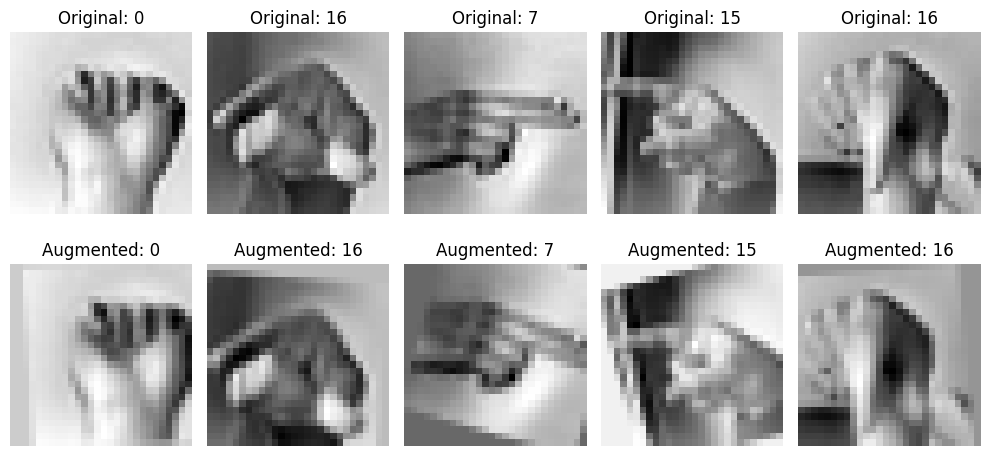

In [10]:
# print Examples of augmented images
import matplotlib.pyplot as plt
# change X_trian type to float64 before plot
# X_train_imgs = X_train_imgs.astype(np.float64)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    axes[0, i].imshow(X_train_imgs[i], cmap='gray')
    axes[0, i].set_title(f'Original: {y_train.iloc[i]}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(aug_imgs[i], cmap='gray')
    axes[1, i].set_title(f'Augmented: {y_train.iloc[i]}')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()
# ================================


In [11]:
# ================================

# 5. Train MLP

# ================================

  
model = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        alpha= 0.0001,                 # ← regularization strength
        # early_stopping=True,     # ← use internal validation for early stopping
        validation_fraction=0.1, # ← 10% of X_train used internally
        n_iter_no_change=10,     # ← patience for early stopping
        max_iter=60,
        random_state=42
    )
model.fit(X_train_aug, y_train_aug)

print("Model converged in", model.n_iter_, "epochs.")


Model converged in 60 epochs.


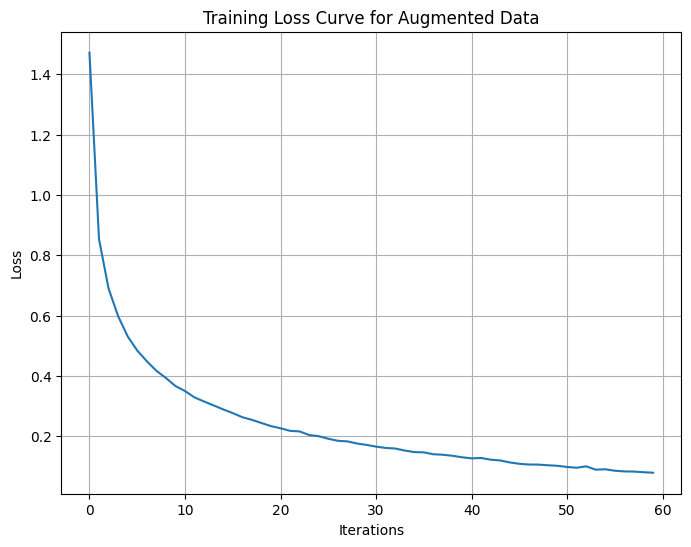

In [12]:
# Plot training loss curve for augmented model
plt.figure(figsize=(8,6))
plt.plot(model.loss_curve_)
plt.title("Training Loss Curve for Augmented Data")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [13]:
# ================================

# 6. Evaluation

# ================================
train_accuracy = model.score(X_train_aug, y_train_aug)* 100
print(f"Training Accuracy on Augmented Data: { train_accuracy:.4f}%")

val_accuracy = accuracy_score(y_validate, model.predict(X_validate))* 100
print(f"Validation Accuracy on Augmented Data: {val_accuracy:.4f}%")

y_pred_test =  model.predict(X_test)
test_accuracy = accuracy_score(y_test,y_pred_test)* 100
print(f"Test Accuracy on Augmented Data: {test_accuracy:.4f}%")


print("Report on Test Data:")
print(classification_report(y_test,model.predict(X_test)))

Training Accuracy on Augmented Data: 98.2719%
Validation Accuracy on Augmented Data: 99.9636%
Test Accuracy on Augmented Data: 82.4317%
Report on Test Data:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       331
           1       0.95      0.85      0.90       432
           2       0.98      0.91      0.94       310
           3       0.57      0.84      0.68       245
           4       0.94      0.92      0.93       498
           5       0.83      1.00      0.91       247
           6       0.90      0.88      0.89       348
           7       0.97      0.93      0.95       436
           8       0.75      0.88      0.81       288
          10       0.82      0.76      0.79       331
          11       0.98      0.99      0.98       209
          12       0.69      0.88      0.77       394
          13       0.78      0.57      0.66       291
          14       0.92      0.98      0.94       246
          15       1.00      0.9

----------
Per-class Test Accuracies for Augmented Dataset:
Class 0:  95%
Class 1:  85%
Class 2:  91%
Class 3:  84%
Class 4:  92%
Class 5: 100%
Class 6:  88%
Class 7:  93%
Class 8:  88%
Class 10:  76%
Class 11:  99%
Class 12:  88%
Class 13:  57%
Class 14:  98%
Class 15:  94%
Class 16:  87%
Class 17:  81%
Class 18:  65%
Class 19:  72%
Class 20:  57%
Class 21:  57%
Class 22:  65%
Class 23:  87%
Class 24:  69%


Text(0.5, 192.72222222222217, 'Predicted label')

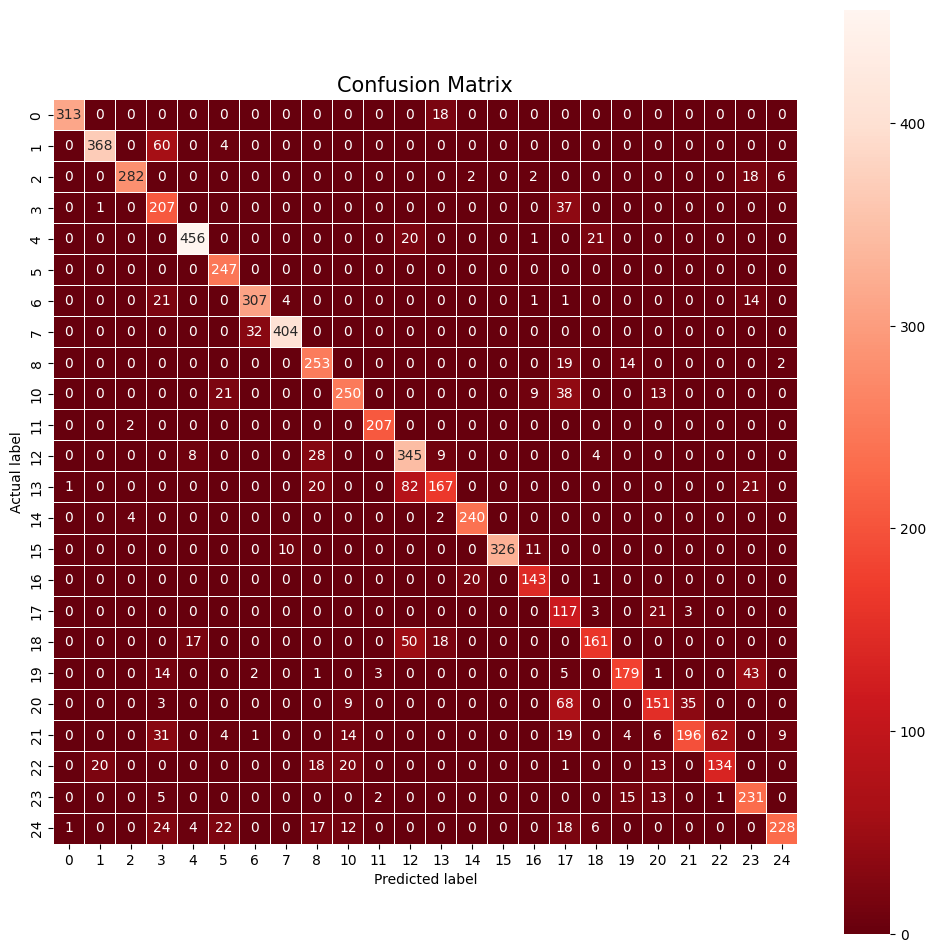

In [14]:
# Create dictionaries to hold counts
correct_counts = defaultdict(int) # number of times the model predicted this class correctly
total_counts = defaultdict(int) # total number of test samples belonging to this class

# Count correct predictions and total predictions for each class
for true, pred in zip(y_test, y_pred_test):
    total_counts[true] += 1
    if true == pred:
        correct_counts[true] += 1 

# Calculate and print accuracy for each class
print(f"----------")
print("Per-class Test Accuracies for Augmented Dataset:")
for class_id in sorted(total_counts.keys()):
    accuracy = correct_counts[class_id] / total_counts[class_id] * 100
    print(f"Class {class_id}: {accuracy:3.0f}%")

# Generate confusion matrix to find most misidentified classes
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_labels = sorted(list(set(y_test))) # class labels are the unique values in y_test which are sorted so that they correspond to the confusion matrix rows/columns

# Confusion matrix heatmap 
# Shows how often each class is predicted as each other class
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, annot=True, 
            linewidths=.5, square = True, cmap = 'Reds_r', fmt='0.4g', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix', size = 15)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')